In [1]:
import sys
sys.path.append("/home/an0104ro/ece-scm-coupling")
%matplotlib inline

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from AOSCMcoupling.convergence_checker import vector_norm, relative_error, relative_criterion, ConvergenceChecker
from AOSCMcoupling.files import OIFSPreprocessor, NEMOPreprocessor, OASISPreprocessor

plt.style.use('rc.mplstyle')
plotting_output_dir = Path(f"Plots_for_Thesis")
plotting_output_dir.mkdir(exist_ok=True, parents = True)

In [2]:
output_dir= Path("/home/an0104ro/experiments_reanalysis/output_control_experiment_50_iter")

target_latitudes = [79.0,80.0, 81.0]
target_longitudes = [1.0, 2.5, 4.0, 5.5, 7.0]
lon_lats = [(lon, lat) for lon in target_longitudes for lat in target_latitudes]

In [3]:
ece4_dir_pathsP  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/RPP/") for lon, lat in lon_lats]
Init_ice = [
    xr.open_mfdataset(
          f"{ece4_dir}/Ice_initialization.nc"
    )
    for ece4_dir in ece4_dir_pathsP 
]

init_conc = [ds['a_i'].values[0,0,0] for ds in Init_ice]

In [4]:
TOL = 10**-3
max_iters = 30
number_iterations = []

for lon, lat in lon_lats:

    #start_date = pd.Timestamp(f"2023-05-28")
    exp_id = f"lon_{lon}_lat_{lat}/SWR/RSW"
    check_conv = ConvergenceChecker()
    l2_subs = []
    inf_subs = []
    schwarz_dir_ref = output_dir / f"{exp_id}_{1}"
    print(schwarz_dir_ref )

    # check termination criterium
    for iter in range(1, max_iters):
        schwarz_dir_iter = output_dir / f"{exp_id}_{iter}"
        schwarz_dir_next_iter = output_dir / f"{exp_id}_{iter + 1}"
        l2, inf = check_conv.check_convergence(
            schwarz_dir_iter, schwarz_dir_next_iter, reference_dir = schwarz_dir_ref, tolerance = TOL
        )
        l2_subs.append(l2)
        inf_subs.append(inf)

        print(f"Iter {iter}: {l2=}, {inf=}")

    # iteration value for convergence, + 2 since indixes is shifted by one and convergence iteration is the true after the last false.
    last_false_index = len(inf_subs) - 1 - inf_subs[::-1].index(False) + 2
    number_iterations.append(last_false_index)

# gives the last iteration where the algorithm is not converged. Thus, if the number of iterations is 20, the algorithm is not terminated for the given criterium!
number_iterations =  np.array(number_iterations)

/home/an0104ro/experiments_reanalysis/output_control_experiment_50_iter/lon_1.0_lat_79.0/SWR/RSW_1
Iter 1: l2=False, inf=False
Iter 2: l2=False, inf=False
Iter 3: l2=False, inf=False
Iter 4: l2=False, inf=False
Iter 5: l2=False, inf=False
Iter 6: l2=False, inf=False
Iter 7: l2=False, inf=False
Iter 8: l2=False, inf=False
Iter 9: l2=False, inf=False
Iter 10: l2=False, inf=False
Iter 11: l2=False, inf=False
Iter 12: l2=False, inf=False
Iter 13: l2=False, inf=False
Iter 14: l2=False, inf=False
Iter 15: l2=False, inf=False
Iter 16: l2=False, inf=False
Iter 17: l2=False, inf=False
Iter 18: l2=False, inf=False
Iter 19: l2=False, inf=False
Iter 20: l2=False, inf=False
Iter 21: l2=False, inf=False
Iter 22: l2=False, inf=False
Iter 23: l2=False, inf=False
Iter 24: l2=False, inf=False
Iter 25: l2=False, inf=False
Iter 26: l2=False, inf=False
Iter 27: l2=False, inf=False
Iter 28: l2=False, inf=False
Iter 29: l2=False, inf=False
/home/an0104ro/experiments_reanalysis/output_control_experiment_50_it

Indices of non-converged: [ 0  1  2  3  4  5  7  8 10 11 13 14]
Non-converged init_conc_thic values: [0.71926785 0.89423734 0.93392915 0.09979536 0.89118987 0.93681175
 0.86683977 0.94391823 0.6529119  0.95139772 0.21305273 0.95018589]


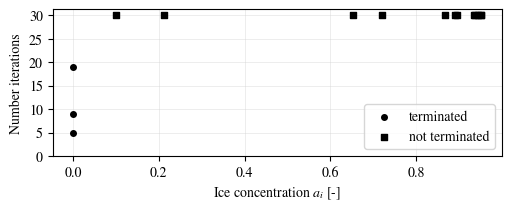

In [5]:
# extract not converged arrays
index_not_converged = np.where(number_iterations == max_iters)[0]
number_iterations_not_conv = number_iterations[index_not_converged]
print("Indices of non-converged:", index_not_converged)

# extract the initial conditions
dependency = np.array(init_conc)
dependency_not_conv = dependency[index_not_converged]
print("Non-converged init_conc_thic values:", dependency_not_conv)

# Plot number iterations
fig, axs = plt.subplots(ncols=1, nrows = 1, figsize = (5,2), constrained_layout= True)

axs.scatter(dependency, number_iterations, marker='o', color = "k", zorder=10,
           label='terminated')
axs.scatter(dependency_not_conv, number_iterations_not_conv, marker='s', 
            color = 'k', s =  20, zorder=10, label='not terminated')
axs.set_xlabel(r'Ice concentration $a_i$ [-] ')
axs.set_ylabel(r'Number iterations')
axs.set_yticks([0,5,10,15,20,25, 30])

axs.legend(loc='lower right')

fig.savefig('Plots_for_Thesis/terminated_or_not.pdf')
